# Cyanobacteria Toxicity Classification Notebook with Cross-Validation

## 1. Setup & Configuration

In [2]:
import os
from datetime import date
import math
import subprocess
import yaml
import pandas as pd
import torch
from torchvision.models import ResNet18_Weights
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from torchvision import models, datasets
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm
from src.config_utils import load_config
from PIL import Image
import copy
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import torchvision.transforms as T
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    precision_recall_curve,
    average_precision_score,
    roc_curve,
    brier_score_loss
)
from sklearn.calibration import calibration_curve
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# Chargement de la config
config = load_config(path='../configs/config_finetune_resnet18.yaml')

# Répertoires de sortie
FIG_OUT = os.path.join('..', 'outputs', 'figures', 'Switzerland', 'finetune_resnet18')
os.makedirs(FIG_OUT, exist_ok=True)

# Génération du Run ID : date + commit Git
today = date.today().isoformat()
commit = subprocess.check_output(["git","rev-parse","--short","HEAD"]).decode().strip()
run_id = f"{today}_{commit}"

print("Run ID :", run_id)


Run ID : 2025-07-24_d7670f1


## 2. Data Preparation

In [3]:
# Transforms avec RandomErasing pour dropout spatial
data_cfg = config['augmentation']

train_transform = T.Compose([
    # 1) Crop aléatoire + scale varié
    T.RandomResizedCrop(size=tuple(data_cfg['resize']),
                        scale=(0.8, 1.0)),
    # 2) Flips horizontal + vertical
    T.RandomHorizontalFlip(p=0.5 if data_cfg['horizontal_flip'] else 0.0),
    T.RandomVerticalFlip(p=0.5 if data_cfg['vertical_flip'] else 0.0),
    # 3) Rotation légère
    T.RandomRotation(degrees=data_cfg['rotation']),
    # 4) Variation colorimétrique
    T.ColorJitter(brightness=data_cfg['color_jitter']['brightness'],
                  contrast=  data_cfg['color_jitter']['contrast'],
                  saturation=data_cfg['color_jitter']['saturation'],
                  hue=       data_cfg['color_jitter']['hue']),
    # 5) Passage en tenseur + normalisation
    T.ToTensor(),
    T.Normalize(mean=data_cfg['normalization']['mean'],
                std= data_cfg['normalization']['std']),
    # 6) Masquage partiel (Random Erasing)
    T.RandomErasing(p=data_cfg['random_erasing']['p'],
                    scale=tuple(data_cfg['random_erasing']['scale']),
                    ratio=tuple(data_cfg['random_erasing']['ratio']))
])

val_transform = transforms.Compose([
    transforms.Resize(tuple(data_cfg['resize'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=data_cfg['normalization']['mean'],
                         std=data_cfg['normalization']['std'])
])


In [4]:
# Chargement du dataset et Stratified K-Fold
dataset = datasets.ImageFolder(
    root=os.path.join('..', config['data']['path']),
    transform=train_transform
)
targets = np.array(dataset.targets)


paths = [path for path, _ in dataset.samples]
groups = [os.path.basename(p).split('_')[0] for p in paths]


sgkf = StratifiedGroupKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

fold_to_use = 0  # modifier si besoin (0 à 4)
for fold, (train_idx, val_idx) in enumerate(
        sgkf.split(
            X=np.zeros(len(targets)),
            y=targets,
            groups=groups
        )
    ):
    if fold == fold_to_use:
        print(f"=== Fold {fold+1} sélectionné — "
              f"{len(set(np.array(groups)[train_idx]))} souches en train, "
              f"{len(set(np.array(groups)[val_idx]))} en val ===")
        # Vérif rapide : pas de souche commune
        train_s = set(np.array(groups)[train_idx])
        val_s   = set(np.array(groups)[val_idx])
        assert train_s.isdisjoint(val_s), "Fuite de groupe détectée !"
        break


# Subsets et DataLoaders
train_subset = Subset(dataset, train_idx)
# val_transform pour la validation
val_dataset_full = datasets.ImageFolder(
    root=os.path.join('..', config['data']['path']),
    transform=val_transform
)
val_subset = Subset(val_dataset_full, val_idx)

train_loader = DataLoader(
    train_subset,
    batch_size=config['data']['batch_size'],
    shuffle=True,
    num_workers=config['data']['num_workers']
)
val_loader = DataLoader(
    val_subset,
    batch_size=config['data']['batch_size'],
    shuffle=False,
    num_workers=config['data']['num_workers']
)

print(f"Train samples: {len(train_idx)}, Val samples: {len(val_idx)}")

=== Fold 1 sélectionné — 10 souches en train, 2 en val ===
Train samples: 474, Val samples: 108


## 3. Model Definition

In [5]:
# === EarlyStopping utility ===
class EarlyStopping:
    def __init__(self, patience=5, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience


In [6]:
# Définition du modèle, critère et optimizer
device = torch.device(config['training']['device'])
model = models.resnet18(
    weights=ResNet18_Weights.DEFAULT if config['model']['pretrained'] else None
)

# 1) Tout gèlé
for param in model.parameters():
    param.requires_grad = False

# 2) Nouvelle tête (dropout léger)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(p=0.3),
    nn.Linear(num_ftrs, config['model']['num_classes'])
)

model = model.to(device)


criterion = nn.CrossEntropyLoss()

## 4. Training Loop

In [8]:
history = {'train_loss': [], 'val_loss': []}
num_epochs = config['training']['epochs']
warmup_epochs = 5

### PHASE 1 : warm‑up de la tête seule ###
print("=== Phase 1 : warm‑up de la tête seule (5 epochs) ===")

# 1) Geler tout sauf la tête
for name, param in model.named_parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True

# 2) Optimiseur & scheduler pour la tête
optimizer = optim.AdamW(
    model.fc.parameters(),
    lr=1e-3,  # LR plus élevé pour la tête
    weight_decay=float(config['training']['weight_decay'])
)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
)

# 3) Boucle warm‑up
for epoch in range(1, warmup_epochs+1):
    # --- TRAIN ---
    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader, desc=f"Warmup Epoch {epoch}/{warmup_epochs} - Train"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    history['train_loss'].append(train_loss)

    # --- VAL ---
    model.eval()
    running_val = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val += loss.item() * inputs.size(0)
    val_loss = running_val / len(val_loader.dataset)
    history['val_loss'].append(val_loss)

    scheduler.step(val_loss)
    print(f"Warmup Epoch {epoch} — Train Loss: {train_loss:.4f} — Val Loss: {val_loss:.4f}")

### PHASE 2 : fine‑tuning de layer4 + tête ###
print("=== Phase 2 : fine‑tuning layer4 + tête (up to {} epochs) ===".format(num_epochs))

# 1) Débloquer layer4 + tête
for name, param in model.named_parameters():
    if name.startswith("layer4") or name.startswith("fc"):
        param.requires_grad = True

# 2) Nouvel optimiseur à deux groupes
base_lr = float(config['training']['learning_rate'])
optimizer = optim.AdamW([
    {"params": model.layer4.parameters(), "lr": base_lr * 0.1},
    {"params": model.fc.parameters(),    "lr": base_lr},
], weight_decay=float(config['training']['weight_decay']))

# 3) Scheduler + EarlyStopping
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
)
early_stopper = EarlyStopping(patience=5, min_delta=1e-4)

# 4) Boucle fine‑tuning
for epoch in range(warmup_epochs+1, num_epochs+1):
    # --- TRAIN ---
    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs} - Train"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    history['train_loss'].append(train_loss)

    # --- VAL ---
    model.eval()
    running_val = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val += loss.item() * inputs.size(0)
    val_loss = running_val / len(val_loader.dataset)
    history['val_loss'].append(val_loss)

    scheduler.step(val_loss)
    if early_stopper(val_loss):
        print(f"Early stopping à l'epoch {epoch}")
        break

    print(f"Epoch {epoch}/{num_epochs} — Train Loss: {train_loss:.4f} — Val Loss: {val_loss:.4f}")

=== Phase 1 : warm‑up de la tête seule (5 epochs) ===


Warmup Epoch 1/5 - Train: 100%|██████████| 30/30 [00:38<00:00,  1.29s/it]


Warmup Epoch 1 — Train Loss: 0.4221 — Val Loss: 1.5329


Warmup Epoch 2/5 - Train: 100%|██████████| 30/30 [00:37<00:00,  1.24s/it]


Warmup Epoch 2 — Train Loss: 0.3738 — Val Loss: 1.1163


Warmup Epoch 3/5 - Train: 100%|██████████| 30/30 [00:37<00:00,  1.24s/it]


Warmup Epoch 3 — Train Loss: 0.3954 — Val Loss: 1.9139


Warmup Epoch 4/5 - Train: 100%|██████████| 30/30 [00:37<00:00,  1.24s/it]


Warmup Epoch 4 — Train Loss: 0.3462 — Val Loss: 1.7997


Warmup Epoch 5/5 - Train: 100%|██████████| 30/30 [00:37<00:00,  1.24s/it]


Warmup Epoch 5 — Train Loss: 0.4013 — Val Loss: 1.8609
=== Phase 2 : fine‑tuning layer4 + tête (up to 20 epochs) ===


Epoch 6/20 - Train: 100%|██████████| 30/30 [00:39<00:00,  1.31s/it]


Epoch 6/20 — Train Loss: 0.3658 — Val Loss: 1.6856


Epoch 7/20 - Train: 100%|██████████| 30/30 [00:39<00:00,  1.32s/it]


Epoch 7/20 — Train Loss: 0.3360 — Val Loss: 2.0044


Epoch 8/20 - Train: 100%|██████████| 30/30 [00:39<00:00,  1.31s/it]


Epoch 8/20 — Train Loss: 0.3216 — Val Loss: 2.1401


Epoch 9/20 - Train: 100%|██████████| 30/30 [00:39<00:00,  1.31s/it]


Epoch 9/20 — Train Loss: 0.2804 — Val Loss: 1.7664


Epoch 10/20 - Train: 100%|██████████| 30/30 [00:39<00:00,  1.31s/it]


Epoch 10/20 — Train Loss: 0.3068 — Val Loss: 2.3500


Epoch 11/20 - Train: 100%|██████████| 30/30 [00:39<00:00,  1.32s/it]


Early stopping à l'epoch 11


## 5. Results Visualization

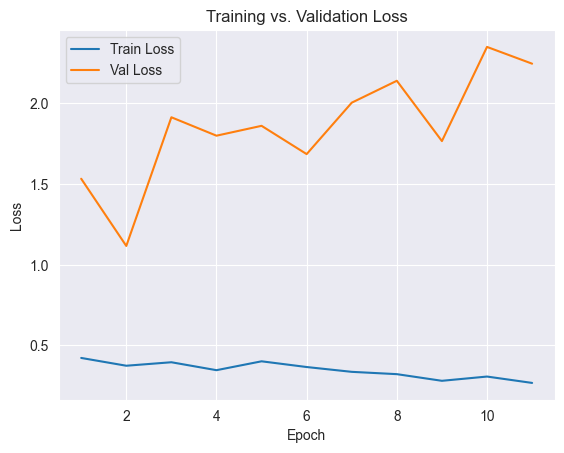

In [10]:
# Affichage des courbes de perte
epochs = np.arange(1, epoch + 1)

plt.figure()
plt.plot(epochs, history['train_loss'], label='Train Loss')
plt.plot(epochs, history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.savefig(os.path.join(FIG_OUT, f"{run_id}_loss_curve.png"), dpi=300)
plt.show()


In [11]:
# Collecte des vraies étiquettes et des probabilités sur la validation
model.eval()
y_true = []
y_prob = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        probs = nn.functional.softmax(outputs, dim=1)[:, 1]
        y_prob.extend(probs.cpu().numpy())
        y_true.extend(labels.numpy())

y_true = np.array(y_true)
y_prob = np.array(y_prob)


In [12]:
# Seuil optimisé à partir de la PR-curve (max F1)
precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
print(f"Seuil optimal (PR-curve) : {best_threshold:.4f} — F1 : {f1_scores[best_idx]:.4f}")


Seuil optimal (PR-curve) : 0.0005 — F1 : 1.0000


ROC AUC : nan — Average Precision (AP) : 1.0000


/Users/titou/Library/Mobile Documents/com~apple~CloudDocs/Documents/UniNe/Projet de Bachelor/Git/microcoleus-project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/titou/Library/Mobile Documents/com~apple~CloudDocs/Documents/UniNe/Projet de Bachelor/Git/microcoleus-project/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/titou/Library/Mobile Documents/com~apple~CloudDocs/Documents/UniNe/Projet de Bachelor/Git/microcoleus-project/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


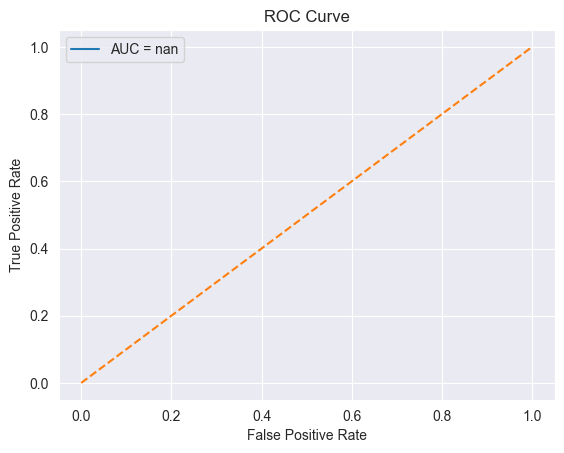

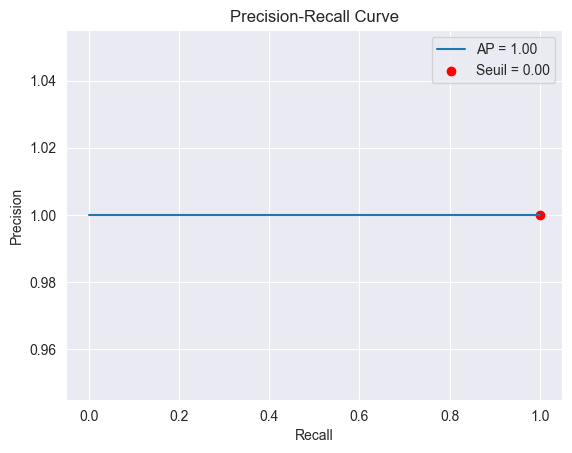

In [13]:
# Calcul des métriques et tracé ROC / PR
y_pred = (y_prob >= best_threshold).astype(int)

# Matrices et scores
cm = confusion_matrix(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_prob)
ap = average_precision_score(y_true, y_prob)

print(f"ROC AUC : {roc_auc:.4f} — Average Precision (AP) : {ap:.4f}")

# ROC
fpr, tpr, _ = roc_curve(y_true, y_prob)
plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1], [0,1], '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.savefig(os.path.join(FIG_OUT, f"{run_id}_roc_curve.png"), dpi=300)
plt.show()

# PR
plt.figure()
plt.plot(recall, precision, label=f'AP = {ap:.2f}')
plt.scatter(recall[best_idx], precision[best_idx], color='red',
            label=f'Seuil = {best_threshold:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.savefig(os.path.join(FIG_OUT, f"{run_id}_pr_curve.png"), dpi=300)
plt.show()


In [14]:
# Calibration + Brier score
prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10)
brier = brier_score_loss(y_true, y_prob)
print(f"Brier score : {brier:.4f}")


Brier score : 0.4986


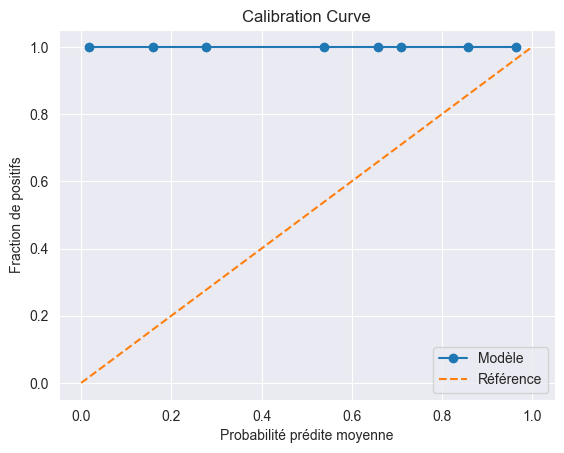

In [15]:
# Tracé de la calibration curve
plt.figure()
plt.plot(prob_pred, prob_true, marker='o', label='Modèle')
plt.plot([0,1], [0,1], '--', label='Référence')
plt.xlabel('Probabilité prédite moyenne')
plt.ylabel('Fraction de positifs')
plt.title('Calibration Curve')
plt.legend()
plt.savefig(os.path.join(FIG_OUT, f"{run_id}_calibration_curve.png"), dpi=300)
plt.show()


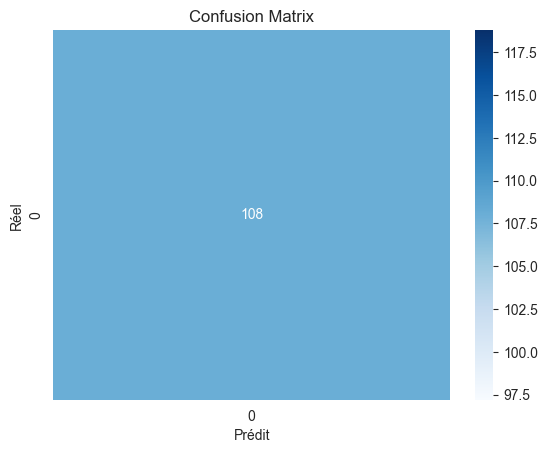

In [16]:
# Matrice de confusion (heatmap)
plt.figure()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.title('Confusion Matrix')
plt.savefig(os.path.join(FIG_OUT, f"{run_id}_confusion_matrix.png"), dpi=300)
plt.show()


In [17]:
# Classification report détaillé
print("Classification Report :")
print(classification_report(y_true, y_pred))


Classification Report :
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       108

    accuracy                           1.00       108
   macro avg       1.00      1.00      1.00       108
weighted avg       1.00      1.00      1.00       108



## 6. Grad-CAM Interpretability

Images sauvegardées dans : ../outputs/figures/Switzerland/finetune_resnet18/2025-07-24_d7670f1_gradcam_batch.png


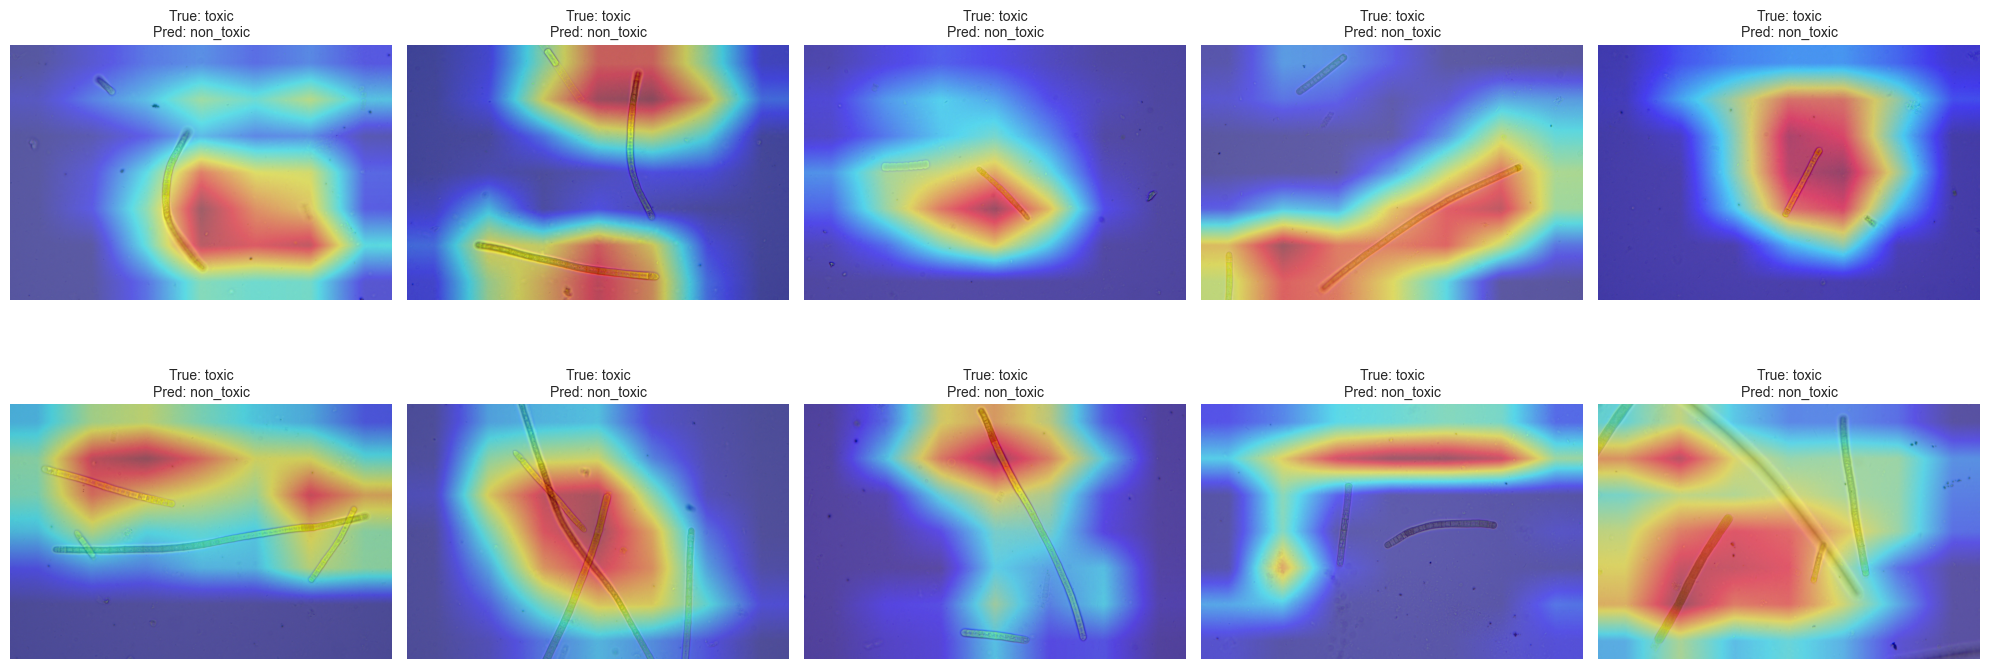

In [18]:
# Récupérer mean et std depuis la config
mean = data_cfg['normalization']['mean']
std  = data_cfg['normalization']['std']

# Transformations pour la visualisation
vis_transform = transforms.Compose([
    transforms.Resize(tuple(data_cfg['resize'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Préparer GradCAM
target_layer = model.layer4[1].conv2
cam_extractor = GradCAM(model=model, target_layers=[target_layer])

# Nombre d'images à afficher
n_display = 10
n_cols = 5
n_rows = math.ceil(n_display / n_cols)

fig, axes = plt.subplots(n_rows, n_cols,
                         figsize=(n_cols * 4, n_rows * 4),
                         dpi=100)
axes = axes.flatten()

classes = val_subset.dataset.classes

for idx in range(n_display):
    ax = axes[idx]

    # Récupérer le chemin et le label vrai
    sample_idx = val_subset.indices[idx]
    img_path, true_label = val_subset.dataset.samples[sample_idx]
    orig_img = Image.open(img_path).convert('RGB')
    W, H = orig_img.size

    # Préparer l'image d'entrée
    orig_resized = transforms.Resize(tuple(data_cfg['resize']))(orig_img)
    input_tensor = vis_transform(orig_resized).unsqueeze(0).to(device)
    input_tensor.requires_grad_(True)

    # Prédiction du modèle
    outputs = model(input_tensor)
    pred_label = outputs.argmax(dim=1).item()

    targets = [ClassifierOutputTarget(pred_label)]

    # Calcul du Grad-CAM
    grayscale_cam = cam_extractor(
        input_tensor=input_tensor,
        targets=targets
    )[0]

    # Redimensionner la carte sur l'image originale
    cam_img = Image.fromarray((grayscale_cam * 255).astype(np.uint8))
    cam_img = cam_img.resize((W, H), resample=Image.BILINEAR)
    cam_resized = np.array(cam_img, dtype=np.float32) / 255.0

    # Superposer la carte sur l'image originale
    rgb_orig = np.array(orig_img, dtype=np.float32) / 255.0
    cam_on_image = show_cam_on_image(rgb_orig, cam_resized, use_rgb=True)

    ax.imshow(cam_on_image)
    ax.set_title(f"True: {classes[true_label]}\nPred: {classes[pred_label]}", fontsize=10)
    ax.axis('off')

# Cacher les axes restants
for ax in axes[n_display:]:
    ax.axis('off')

plt.tight_layout()

# Sauvegarde de la figure
fig_path = os.path.join(FIG_OUT, f"{run_id}_gradcam_batch.png")
plt.savefig(fig_path, dpi=300)
print("Images sauvegardées dans :", fig_path)
plt.show()

## 7. Save Model & Config

In [19]:
# Sauvegarde du modèle et de la config
os.makedirs('../outputs/checkpoints/Switzerland/finetune_resnet18', exist_ok=True)
torch.save(model.state_dict(),
           f'../outputs/checkpoints/Switzerland/finetune_resnet18/{run_id}_model.pth')

os.makedirs('../outputs/configs/Switzerland', exist_ok=True)
with open(f'../outputs/configs/Switzerland/{run_id}_config_finetune_resnet18.yaml', 'w') as f:
    yaml.dump(config, f)

print('Entraînement terminé. Modèle et config enregistrés.')


Entraînement terminé. Modèle et config enregistrés.
